In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import sys

Mounted at /content/drive/


In [ ]:
# !pip install datasets

In [ ]:
# from datasets import load_dataset
# from transformers import pipeline

# dataset = load_dataset("anton-l/superb_demo", "er", split="session1")

# classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-er")
# #labels = classifier(dataset[0]["file"], top_k=5)


### https://www.kaggle.com/code/thithikshunathr/audio-deepfake-detection-lj-speech-and-wavefake

In [ ]:
import os

paths_fake = []
labels_fake = []

paths_real = []
labels_real = []

fake_root_dir = '/content/drive/MyDrive/wavefake/ljspeech_melgan'
real_root_dir = '/content/drive/MyDrive/wavefake/wavs'

for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths_fake.append(file_path)
    # Add label based on the subdirectory name
    labels_fake.append('fake')

for filename in os.listdir(real_root_dir):
    file_path = os.path.join(real_root_dir, filename)
    paths_real.append(file_path)
    # Add label based on the subdirectory name
    labels_real.append('real')

print('Dataset is loaded')

Dataset is loaded


## Sample Fake Audio

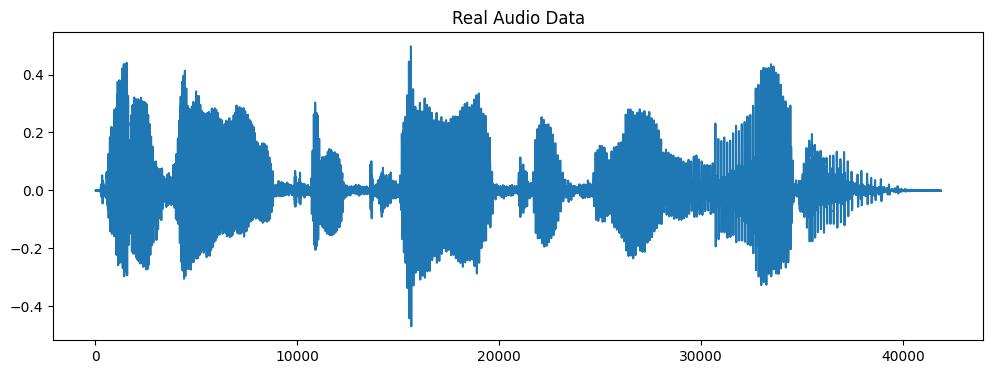

In [ ]:
real_audio_sample1 = '/content/drive/MyDrive/wavefake/wavs/LJ001-0002.wav'
real_ad, real_sr = librosa.load(real_audio_sample1)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

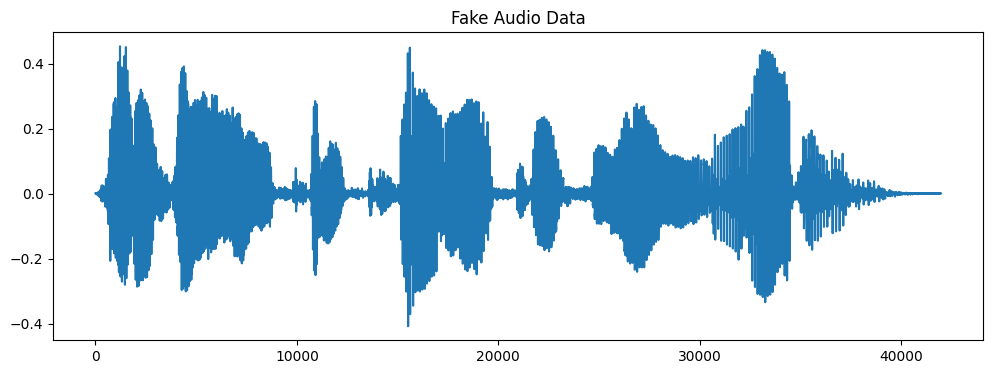

In [ ]:
fake_audio_sample1 = '/content/drive/MyDrive/wavefake/ljspeech_melgan/LJ001-0002_gen.wav'
fake_ad, fake_sr = librosa.load(fake_audio_sample1)
plt.figure(figsize= (12,4))
plt.plot(fake_ad)
plt.title('Fake Audio Data')
plt.show()

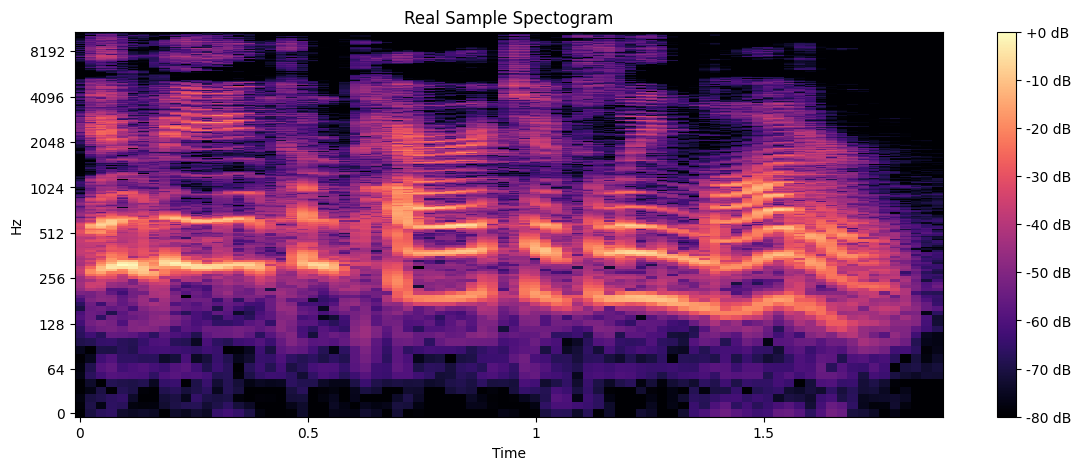

In [ ]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Sample Spectogram")
plt.show()

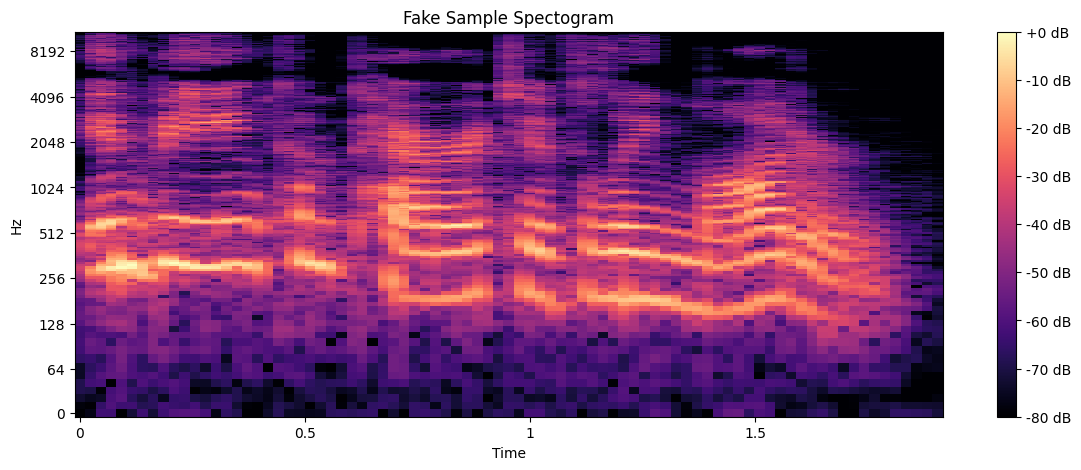

In [ ]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Fake Sample Spectogram")
plt.show()

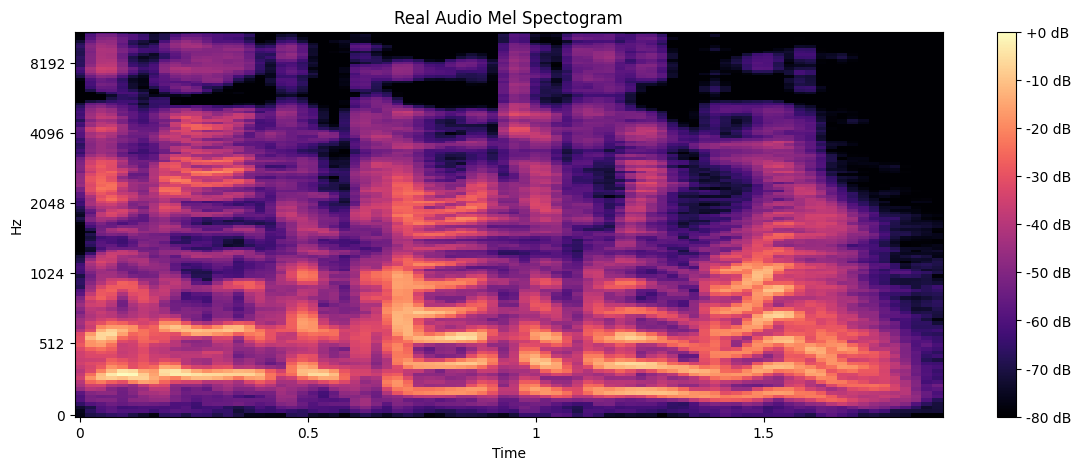

In [ ]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = fake_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

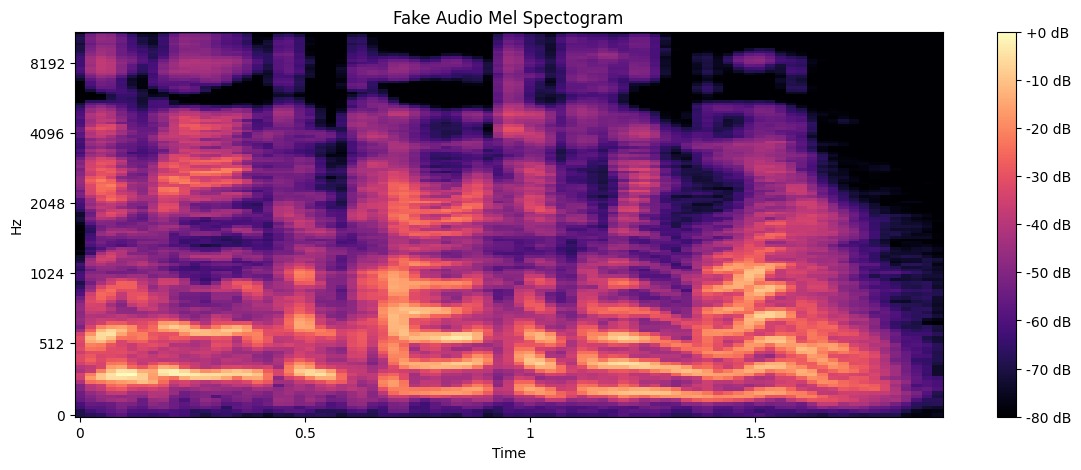

In [ ]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()



** Generative Adversarial Network **

A GAN, or Generative Adversarial Network, is a generative model that simultaneously trains two models: a generative model G
 that captures the data distribution, and a discriminative model D
 that estimates the probability that a sample came from the training data rather than G. The training procedure for G
 is to maximize the probability of D
 making a mistake.

## zero crossing rate

In [ ]:
import librosa
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import IPython.display as ipd
import scipy as spp

In [ ]:
x_real,s_real = librosa.load('/content/drive/MyDrive/wavefake/wavs/LJ001-0002.wav')
zero_crossings_real = librosa.zero_crossings(x_real, pad=False)
print(sum(zero_crossings_real))
zero_crossings_real

3208


array([False,  True, False, ..., False, False, False])

In [ ]:
x_fake,s_fake = librosa.load('/content/drive/MyDrive/wavefake/ljspeech_melgan/LJ001-0002_gen.wav')
zero_crossings_fake = librosa.zero_crossings(x_fake, pad=False)
print(sum(zero_crossings_fake))
zero_crossings_fake

3078


array([False, False, False, ..., False, False, False])

## Band Width Energy

### The band energy ratio is a metric used to quantify the ratio of the energies of the lower frequencies to that of the higher frequencies in a given time frame.

array([9.69424475e+01, 7.40415042e+00, 6.44436757e+00, 1.23909501e+01,
       7.63933791e+02, 6.41409200e+02, 5.99847206e+02, 1.20539114e+02,
       1.79098041e+01, 1.39378202e+01, 1.07233083e+01, 5.44848709e+00,
       4.83483717e+00, 5.14830144e+00, 5.49694821e+00, 1.09401075e+01,
       1.32181368e+02, 3.74114308e+02, 9.62932328e+00, 3.87954902e+00,
       3.45160061e+00, 5.97936739e+02, 1.91579584e+03, 1.45218034e+03,
       1.86285329e+03, 3.73766003e+02, 1.03178378e+01, 7.20300232e+00,
       2.90206397e+00, 2.54285723e+00, 1.86715908e+01, 1.36650333e+01,
       1.48721042e+01, 3.17779195e+01, 6.76328326e+01, 1.89225677e+02,
       2.00168055e+02, 4.46671179e+01, 1.01026091e+01, 2.20673901e+01,
       7.00784537e+00, 1.45617029e-01, 1.90063244e+00, 2.35398103e+01,
       6.10570036e+01, 1.77378164e+02, 5.11900146e+01, 1.22733948e+00,
       1.40778754e+01, 1.35380141e+02, 8.27593720e+01, 7.43116605e+02,
       2.58762326e+02, 5.46710514e+01, 3.60806624e+01, 2.82679759e+02,
      

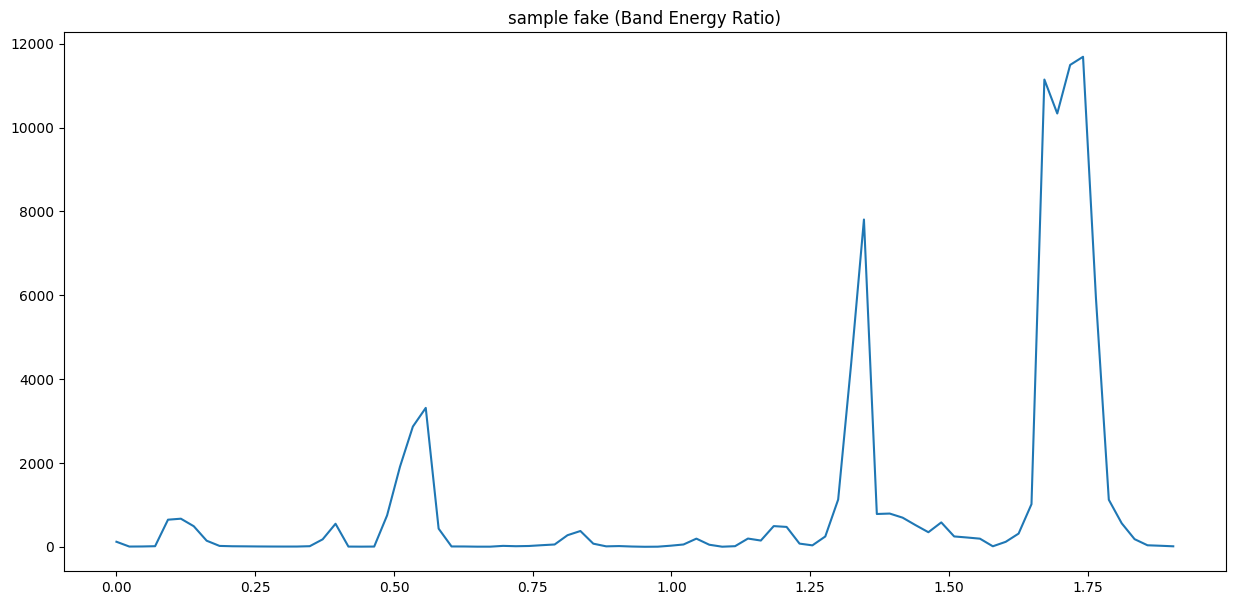

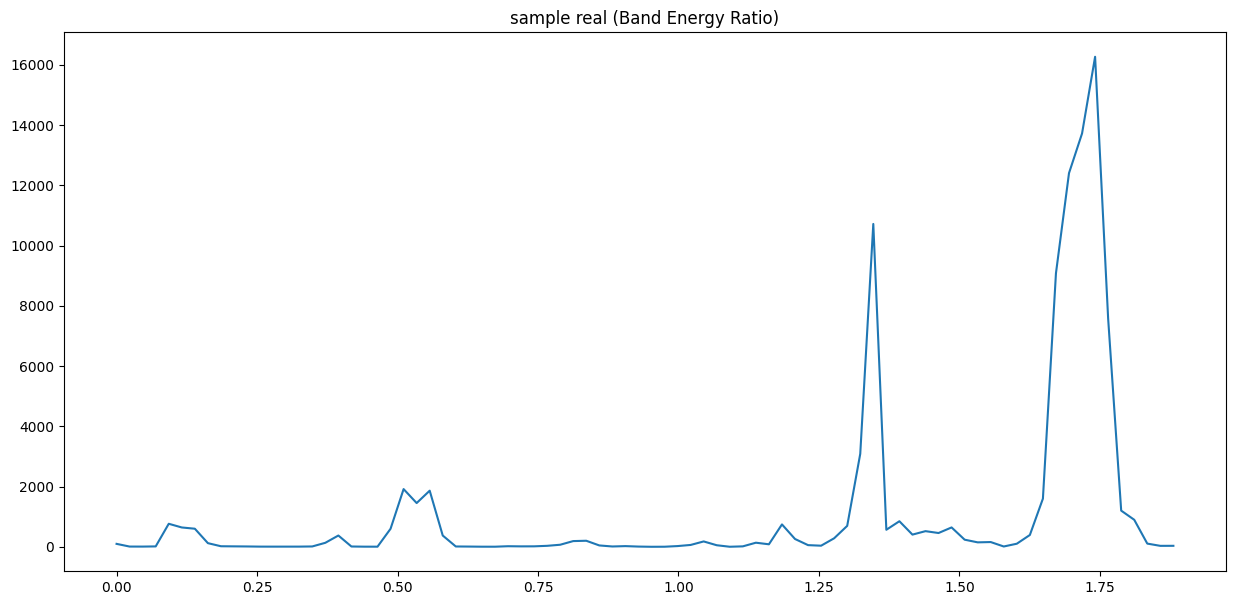

In [ ]:
def find_split_freq_bin(spec, split_freq, sample_rate, frame_size=1024, hop_length=512):
    """
    Calculate the bin index corresponding to a given split frequency.

    Args:
        spec (array): The spectrogram.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        int: The bin index corresponding to the split frequency.
    """
    # Calculate the range of frequencies
    range_of_freq = sample_rate / 2
    # Calculate the change in frequency per bin
    change_per_bin = range_of_freq / spec.shape[0]
    # Calculate the bin corresponding to the split frequency
    split_freq_bin = split_freq / change_per_bin
    return int(np.floor(split_freq_bin))

def band_energy_ratio(signal, split_freq, sample_rate, frame_size=1024, hop_length=512):
    """
    Compute the band energy ratio (BER) of a signal.

    Args:
        signal (array): The input signal.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        ndarray: The band energy ratios for each frame of the signal.
    """
    # Compute the spectrogram of the signal
    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Find the bin corresponding to the split frequency
    split_freq_bin = find_split_freq_bin(spec, split_freq, sample_rate, frame_size, hop_length)
    # Extract the magnitude and transpose it
    modified_spec = np.abs(spec).T
    res = []
    for sub_arr in modified_spec:
        # Compute the energy in the low-frequency range
        low_freq_density = sum(i ** 2 for i in sub_arr[:split_freq_bin])
        # Compute the energy in the high-frequency range
        high_freq_density = sum(i ** 2 for i in sub_arr[split_freq_bin:])
        # Compute the band energy ratio
        ber_val = low_freq_density / high_freq_density
        res.append(ber_val)
    return np.array(res)

def plot_band_energy_ratio(signal, split_freq, sample_rate, name, frame_size=1024, hop_length=512):
    """
    Plot the band energy ratio (BER) of a signal over time.

    Args:
        signal (ndarray): The input signal.
        split_freq (float): The split frequency in Hz.
        sample_rate (int): The sample rate of the audio.
        name (str): The name of the signal for the plot title.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.
    """
    # Compute the band energy ratio (BER)
    ber = band_energy_ratio(signal, split_freq, sample_rate, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(ber))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Plot the BER over time
    plt.plot(time, ber)
    # Set the title of the plot
    plt.title(name + " (Band Energy Ratio)")
    # Show the plot
    # plt.show()
    return ber

plot_band_energy_ratio(x_fake, 2048, s_fake, "sample fake")
plot_band_energy_ratio(x_real, 2048, s_real, "sample real")

## Spectral Centroid

### average frequency of a signal’s spectrum in a given time frame

### Sounds with higher spectral centroids tend to have a brighter or more treble-oriented quality, while lower centroid values are associated with a rather darker or bass-oriented character.

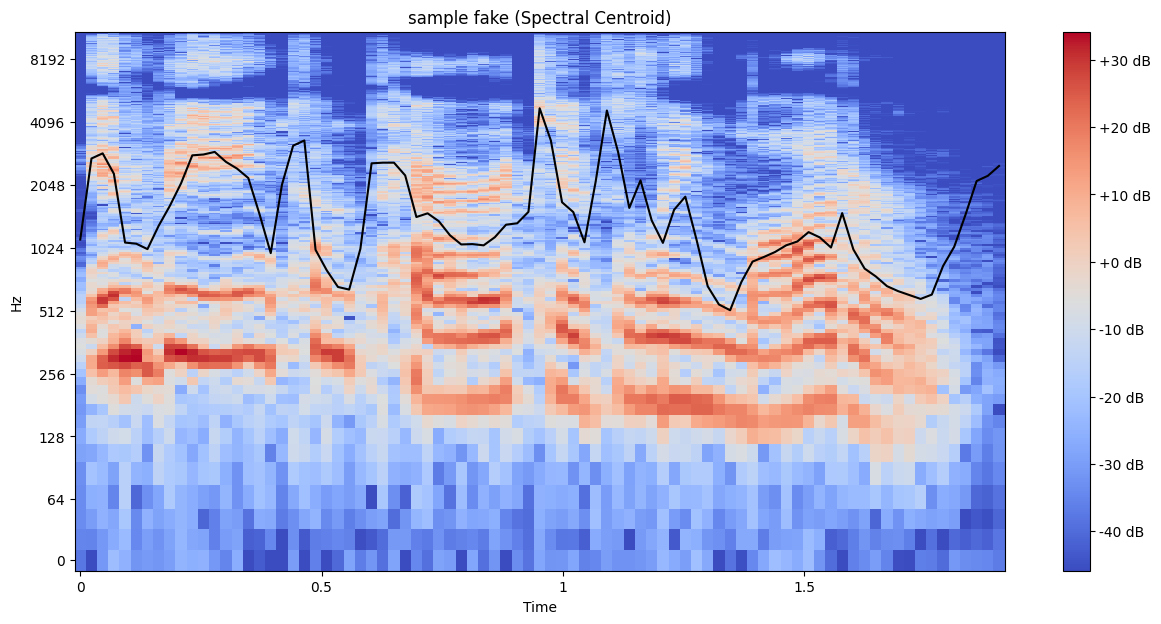

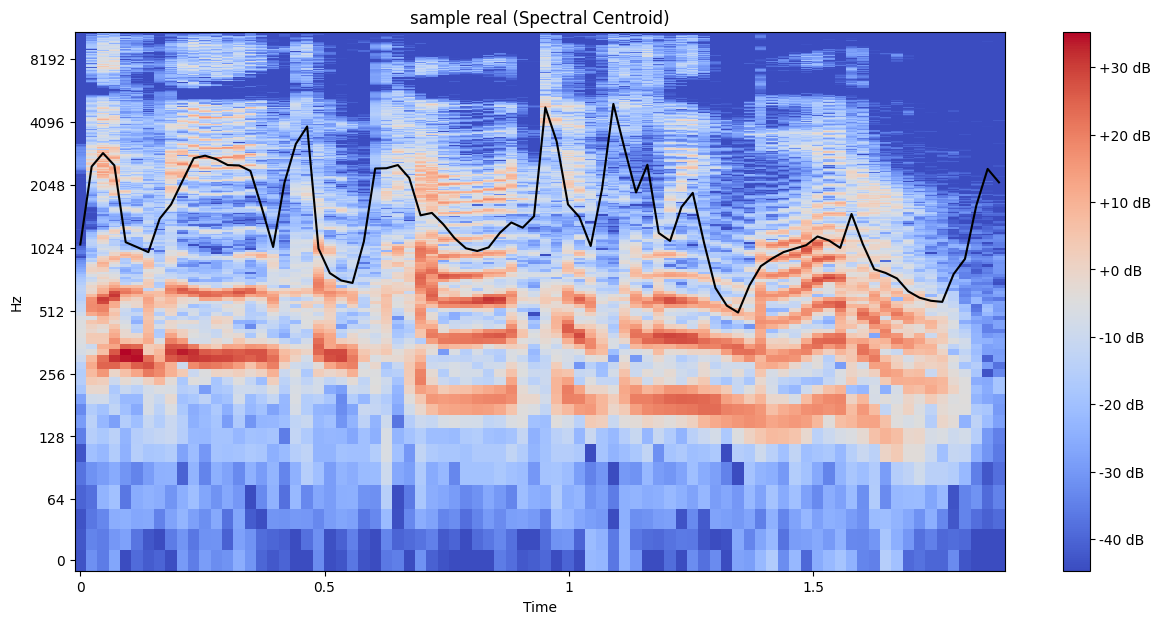

array([ 49.31672141, 116.33492727, 134.89912341, 117.84973318,
        50.57307824,  47.90742035,  45.33560714,  65.51466481,
        76.61353801,  99.11884881, 127.54110624, 131.12182797,
       126.10342354, 118.25792762, 117.77310785, 110.82982593,
        73.86682057,  47.96066776,  97.48136206, 149.20354842,
       180.88991996,  47.19353832,  35.98390452,  33.17516919,
        32.29243266,  50.94755489, 113.83112403, 114.23556374,
       118.26681922, 102.62415345,  68.00532265,  69.82688173,
        61.63761123,  52.8427582 ,  47.29280106,  45.90400071,
        47.76590719,  56.14684187,  62.84578255,  59.34684556,
        67.26143981, 223.17219508, 153.40252998,  76.6475053 ,
        66.72220948,  48.51858263,  90.8557484 , 231.87344977,
       140.75996275,  87.47929498, 118.66364433,  55.96624211,
        51.28057046,  74.42605035,  87.0813658 ,  50.13506741,
        30.55772428,  25.15287066,  23.3079795 ,  31.43827932,
        38.8560187 ,  42.26844474,  45.33972454,  47.11

In [ ]:
def spectral_centroid(signal, sample_rate, frame_size=1024, hop_length=512):
    """
    Compute the Spectral Centroid of a signal.

    Args:
        signal (array): The input signal.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        ndarray: The spectral centroids for each frame of the signal.
    """
    # Compute the spectrogram of the signal
    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Extract the magnitude and transpose it
    modified_spec = np.abs(spec).T
    res = []
    for sub_arr in modified_spec:
        # Compute the spectral centroid
        sc_val = sc(sub_arr)
        # Store the value of spectral centroid for current frame
        res.append(sc_val)
    return np.array(res)

def sc(arr):
    """
    Computes the spectral centroid in a signal.

    Args:
        arr (array): Frequency domain array for current frame.

    Returns:
        float: The spectral centroid value for current frame.
    """
    res = 0
    for i in range(0, len(arr)):
        # Compute weighted sum
        res += i*arr[i]
    return res/sum(arr)

def bin_to_freq(spec, bin_val, sample_rate, frame_size=1024, hop_length=512):
    """
    Calculate the frequency corresponding to a given bin value

    Args:
        spec (array): The spectrogram.
        bin_val (): The bin value.
        sample_rate (int): The sample rate of the audio.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.

    Returns:
        int: The bin index corresponding to the split frequency.
    """
    # Calculate the range of frequencies
    range_of_freq = sample_rate / 2
    # Calculate the change in frequency per bin
    change_per_bin = range_of_freq / spec.shape[0]
    # Calculate the frequency corresponding to the bin
    split_freq = bin_val*change_per_bin
    return split_freq

def plot_spectral_centroid(signal, sample_rate, name, frame_size=1024, hop_length=512, col = "black"):
    """
    Plot the spectral centroid of a signal over time.

    Args:
        signal (ndarray): The input signal.
        sample_rate (int): The sample rate of the audio.
        name (str): The name of the signal for the plot title.
        frame_size (int, optional): The size of each frame in samples. Default is 1024.
        hop_length (int, optional): The number of samples between consecutive frames. Default is 512.
    """
    # Compute the STFT
    spectrogram = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    # Convert the STFT to dB scale
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))
    # Compute the Spectral Centroid
    sc_arr = spectral_centroid(signal, sample_rate, frame_size, hop_length)
    # Compute corresponding frequencies:
    sc_freq_arr = bin_to_freq(spectrogram_db, sc_arr, sample_rate, frame_size, hop_length)
    # Generate the frame indices
    frames = range(0, len(sc_arr))
    # Convert frames to time
    time = librosa.frames_to_time(frames, hop_length=hop_length)
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Display the Spectrogram
    librosa.display.specshow(spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
    # Add a colorbar to show the magnitude scale
    plt.colorbar(format='%+2.0f dB')
    # Plot the Spectral Centroid over time
    plt.plot(time, sc_freq_arr, color=col)
    # Set the title of the plot
    plt.title(name + " (Spectral Centroid)")
    # Show the plot
    plt.show()
    return sc_arr

plot_spectral_centroid(x_fake, s_fake, "sample fake")
plot_spectral_centroid(x_real, s_real, "sample real")

# PCA

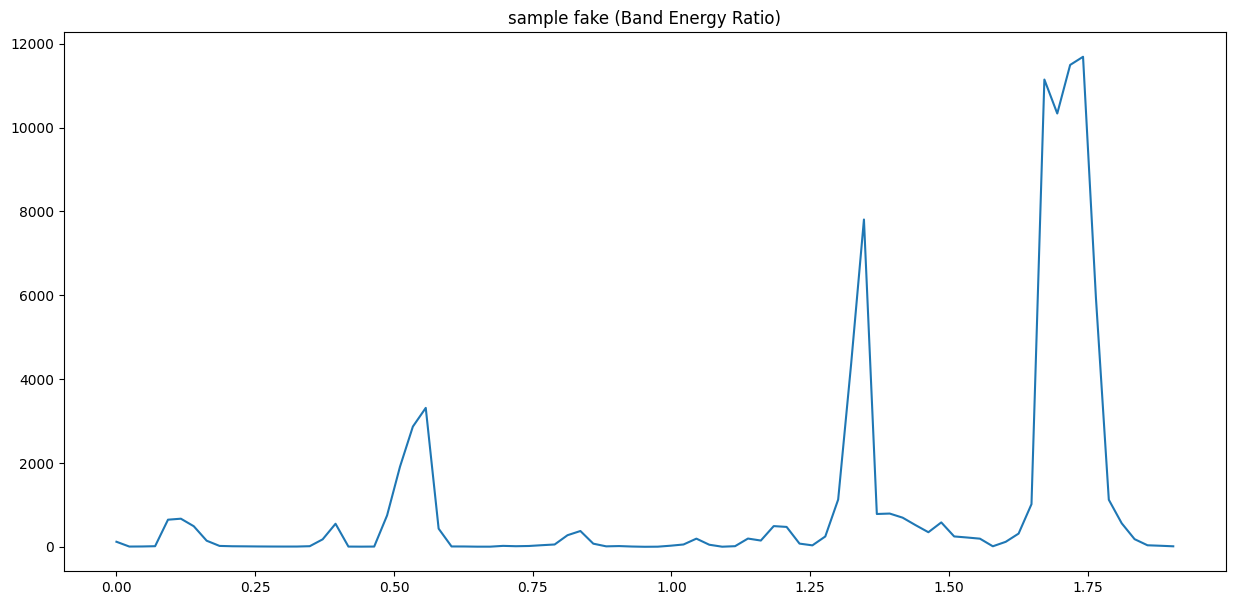

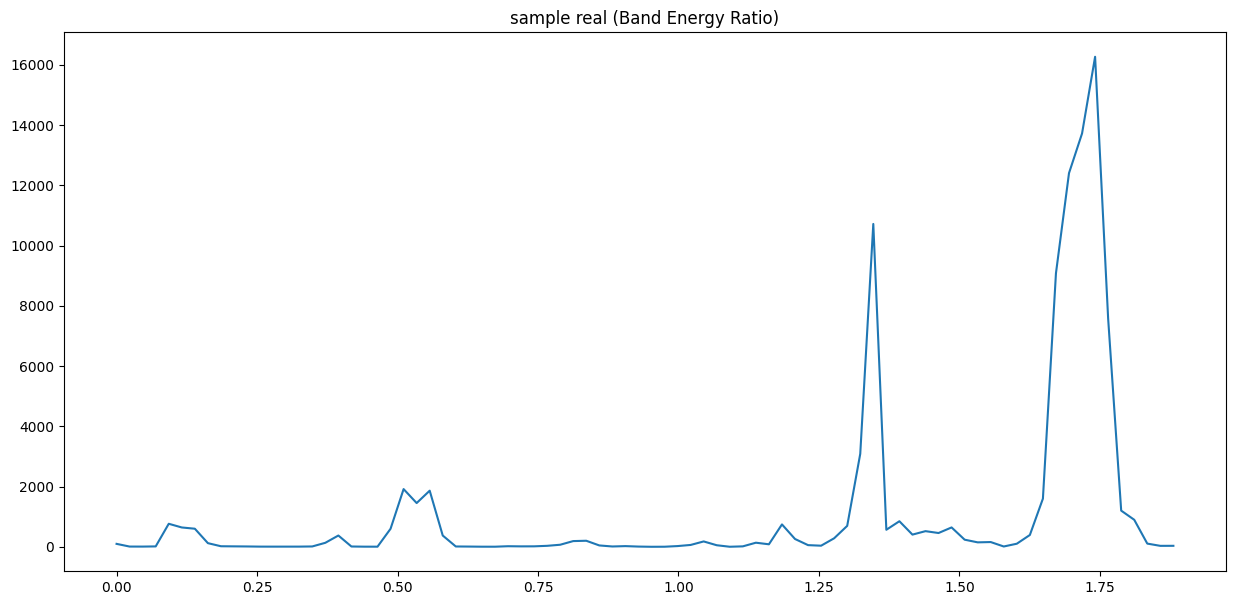

In [ ]:
combined_df_real = pd.DataFrame([])
combined_df_fake = pd.DataFrame([])

combined_df_real['band_energy_ratio'] = plot_band_energy_ratio(x_fake, 2048, s_fake, "sample fake")
combined_df_fake['band_energy_ratio'] = plot_band_energy_ratio(x_real, 2048, s_real, "sample real")

In [ ]:
np.median(band_energy_ratio(x_real, 2048, s_real))

99.33278207955514

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def extract_features(df, target_feature):
  # Assume df is your dataframe with 'time' and 'target_feature' columns
  df[target_feature + ' '+ 'mean'] = df[target_feature].mean()
  df[target_feature + ' '+ 'std_dev'] = df[target_feature].std()
  df[target_feature + ' '+ 'variance'] = df[target_feature].var()
  df[target_feature + ' '+ 'min'] = df[target_feature].min()
  df[target_feature + ' '+ 'max'] = df[target_feature].max()
  df[target_feature + ' '+ 'median'] = df[target_feature].median()
  df[target_feature + ' '+ 'range'] = df[target_feature + ' '+ 'max'] - df[target_feature + ' '+ 'min']
  df[target_feature + ' '+ 'skewness'] = skew(df[target_feature])
  df[target_feature + ' '+ 'kurtosis'] = kurtosis(df[target_feature])
  df[target_feature + ' '+ 'quantile_10'] = df[target_feature].quantile(0.1)
  df[target_feature + ' '+ 'quantile_25'] = df[target_feature].quantile(0.25)
  df[target_feature + ' '+ 'quantile_50'] = df[target_feature].quantile(0.5)
  df[target_feature + ' '+ 'quantile_75'] = df[target_feature].quantile(0.75)
  df[target_feature + ' '+ 'quantile_90'] = df[target_feature].quantile(0.9)

  # Rolling window features
  df[target_feature + ' '+ 'rolling_mean_3'] = df[target_feature].rolling(window=3).mean()
  df[target_feature + ' '+ 'rolling_std_3'] = df[target_feature].rolling(window=3).std()

  # Peak features
  peaks, _ = find_peaks(df[target_feature])
  df[target_feature + ' '+ 'num_peaks'] = len(peaks)
  df[target_feature + ' '+ 'peak_heights'] = df[target_feature][peaks].mean() if len(peaks) > 0 else 0

  # Entropy feature (requires entropy from scipy.stats or other libraries)
  from scipy.stats import entropy
  df[target_feature + ' '+ 'entropy'] = entropy(df[target_feature].value_counts())

  # Autocorrelation (lag-1)
  df[target_feature + ' '+ 'autocorrelation_lag1'] = df[target_feature].autocorr(lag=1)

  # Extract Fourier Transform features (simplified example)
  fft_values = np.fft.fft(df[target_feature])
  df[target_feature + ' '+ 'fft_real_mean'] = np.mean(np.real(fft_values))
  df[target_feature + ' '+ 'fft_imag_mean'] = np.mean(np.imag(fft_values))

  return df



In [ ]:
extract_features(combined_df_real, 'band_energy_ratio')

,band_energy_ratio,band_energy_ratio mean,band_energy_ratio std_dev,band_energy_ratio variance,band_energy_ratio min,band_energy_ratio max,band_energy_ratio median,band_energy_ratio range,band_energy_ratio skewness,band_energy_ratio kurtosis,...,band_energy_ratio quantile_75,band_energy_ratio quantile_90,band_energy_ratio rolling_mean_3,band_energy_ratio rolling_std_3,band_energy_ratio num_peaks,band_energy_ratio peak_heights,band_energy_ratio entropy,band_energy_ratio autocorrelation_lag1,band_energy_ratio fft_real_mean,band_energy_ratio fft_imag_mean
0,119.959618,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,NaN,NaN,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
1,5.477197,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,NaN,NaN,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
2,7.529761,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,44.322192,65.511972,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
3,13.843093,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,8.950017,4.360035,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
4,646.396020,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,222.589625,367.040679,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,561.012244,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,2541.542970,2957.775845,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
79,181.815203,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,621.651665,473.079995,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
80,36.036921,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,259.621456,270.998399,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13
81,24.567318,1045.841336,2606.064226,6.791571e+06,0.188345,11691.000203,119.959618,11690.811859,3.194017,9.180452,...,555.132208,2675.896494,80.806481,87.663900,14,2703.896125,4.418841,0.77709,119.959618,-1.753243e-13


In [ ]:
pd.Series(band_energy_ratio(x_real, 2048, s_real)).value_counts()

96.942448       1
404.096626      1
565.001104      1
10719.846186    1
3086.936779     1
               ..
10.317838       1
373.766003      1
1862.853291     1
1452.180341     1
32.247122       1
Name: count, Length: 82, dtype: int64

## PCA Band Width Energy

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks


def pca_data(k, path_real_or_fake):
  feature_dict = {
      'mean': [],
      'std_dev': [],
      'variance': [],
      'min': [],
      'max': [],
      'median': [],
      'range': [],
      'skewness': [],
      'kurtosis': [],
      'quantile_10': [],
      'quantile_25': [],
      'quantile_50': [],
      'quantile_75': [],
      'quantile_90': [],
      'rolling_mean_3': [],
      'rolling_std_3': [],
      'num_peaks': [],
      'peak_heights': [],
      'entropy': [],
      'autocorrelation_lag1': [],
      'fft_real_mean': [],
      'fft_imag_mean': []
  }
  for i in range(k):
    x, sr = librosa.load(path_real_or_fake[i])
    df = band_energy_ratio(x, 2048, sr)

    feature_dict['mean'].append(df.mean())
    feature_dict['std_dev'].append(df.std())
    feature_dict['variance'].append(df.var())
    feature_dict['min'].append(df.min())
    feature_dict['max'].append(df.max())
    feature_dict['median'].append(np.median(df))
    feature_dict['range'].append(df.max() - df.min())
    feature_dict['skewness'].append(skew(df))
    feature_dict['kurtosis'].append(kurtosis(df))
    feature_dict['quantile_10'].append(np.quantile(df, 0.1))
    feature_dict['quantile_25'].append(np.quantile(df, 0.25))
    feature_dict['quantile_50'].append(np.quantile(df, 0.5))
    feature_dict['quantile_75'].append(np.quantile(df, 0.75))
    feature_dict['quantile_90'].append(np.quantile(df, 0.9))

    rolling_mean_3 = pd.Series(df).rolling(window=3).mean()
    rolling_std_3 = pd.Series(df).rolling(window=3).std()
    feature_dict['rolling_mean_3'].append(rolling_mean_3.mean())
    feature_dict['rolling_std_3'].append(rolling_std_3.mean())

    peaks, _ = find_peaks(df)
    feature_dict['num_peaks'].append(len(peaks))
    feature_dict['peak_heights'].append(df[peaks].mean() if len(peaks) > 0 else 0)

    feature_dict['entropy'].append(entropy(pd.Series(df).value_counts()))

    feature_dict['autocorrelation_lag1'].append(pd.Series(df).autocorr(lag=1))

    fft_values = np.fft.fft(df)
    feature_dict['fft_real_mean'].append(np.mean(np.real(fft_values)))
    feature_dict['fft_imag_mean'].append(np.mean(np.imag(fft_values)))
  return feature_dict


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def draw_tsne(df_real, df_fake):
  df_real['Label'] = 'Real'
  df_fake['Label'] = 'Fake'

  combined_df = pd.concat([df_real, df_fake], ignore_index=True)

  # numerical_cols = ['mean', 'std_dev', 'variance', 'min', 'max', 'median', 'range',
  #       'skewness', 'kurtosis', 'quantile_10', 'quantile_25', 'quantile_50',
  #       'quantile_75', 'quantile_90', 'rolling_mean_3', 'rolling_std_3',
  #       'num_peaks', 'peak_heights', 'entropy', 'autocorrelation_lag1',
  #       'fft_real_mean', 'fft_imag_mean']

    # Exclude the 'Label' column using list comprehension
  df_excluded = combined_df[[col for col in combined_df.columns if col != 'Label']]

  df_excluded = df_excluded.replace('None', pd.NA)

  medians = df_excluded.median()
  df_excluded = df_excluded.fillna(medians)

  # Standardize the features
  x = df_excluded.values
  x = StandardScaler().fit_transform(x)

  # Perform t-SNE
  tsne = TSNE(n_components=2, random_state=42)
  tsne_components = tsne.fit_transform(x)
  tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])

  # Combine t-SNE results with labels
  final_df = pd.concat([tsne_df, combined_df[['Label']]], axis=1)

  # Plotting
  fig, ax = plt.subplots(figsize=(8, 6))

  colors = {'Real': 'blue', 'Fake': 'red'}
  for label, color in colors.items():
      indices_to_keep = final_df['Label'] == label
      ax.scatter(final_df.loc[indices_to_keep, 't-SNE1'],
                final_df.loc[indices_to_keep, 't-SNE2'],
                c=color,
                s=50,
                label=label,
                alpha=0.5)

  ax.legend()
  ax.grid()
  ax.set_xlabel('t-SNE Component 1')
  ax.set_ylabel('t-SNE Component 2')
  ax.set_title('t-SNE of Real vs Fake Data')
  plt.show()


In [ ]:
def draw_pca(df_real, df_fake):
  df_real['Label'] = 'Real'
  df_fake['Label'] = 'Fake'

  combined_df = pd.concat([df_real, df_fake], ignore_index=True)

  # numerical_cols = ['mean', 'std_dev', 'variance', 'min', 'max', 'median', 'range',
  #       'skewness', 'kurtosis', 'quantile_10', 'quantile_25', 'quantile_50',
  #       'quantile_75', 'quantile_90', 'rolling_mean_3', 'rolling_std_3',
  #       'num_peaks', 'peak_heights', 'entropy', 'autocorrelation_lag1',
  #       'fft_real_mean', 'fft_imag_mean']


  # combined_df[numerical_cols] = combined_df[numerical_cols].replace('None', pd.NA)

  # medians = combined_df[numerical_cols].median()
  # combined_df[numerical_cols] = combined_df[numerical_cols].fillna(medians)
  df_excluded = combined_df[[col for col in combined_df.columns if col != 'Label']]

  df_excluded = df_excluded.replace('None', pd.NA)

  medians = df_excluded.median()
  df_excluded = df_excluded.fillna(medians)


  from sklearn.preprocessing import StandardScaler

  x = df_excluded.values

  x = StandardScaler().fit_transform(x)

  from sklearn.decomposition import PCA

  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(x)
  principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

  final_df = pd.concat([principal_df, combined_df[['Label']]], axis=1)

  import matplotlib.pyplot as plt

  fig, ax = plt.subplots(figsize=(8, 6))

  colors = {'Real': 'blue', 'Fake': 'red'}
  for label, color in colors.items():
      indices_to_keep = final_df['Label'] == label
      ax.scatter(final_df.loc[indices_to_keep, 'PC1'],
                final_df.loc[indices_to_keep, 'PC2'],
                c=color,
                s=50,
                label=label,
                alpha=0.5)

  ax.legend()
  ax.grid()
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_title('PCA of Real vs Fake Data')
  plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

def cluster_and_draw_pca(df_real, df_fake):
    """
    Perform K-Means clustering on the provided DataFrame and visualize the results using PCA.

    Parameters:
    - features_df (pd.DataFrame): DataFrame containing features and labels ('real' or 'fake').

    Returns:
    - None
    """
    df_real['Label'] = 'Real'
    df_fake['Label'] = 'Fake'

    combined_df = pd.concat([df_real, df_fake], ignore_index=True)
    combined_df = combined_df.dropna(subset=['Label'])


    # Standardize the features
    features = combined_df.drop(columns=['Label'])
    features =features.replace('None', pd.NA)
    medians = features.median()
    features = features.fillna(medians)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(features_scaled)

    # Create a DataFrame with the K-Means results
    kmeans_df = pd.DataFrame(features_scaled, columns=features.columns)
    kmeans_df['Label'] = combined_df['Label'].map({'Real': 0, 'Fake': 1})
    kmeans_df['cluster'] = kmeans_labels

    # Perform PCA for visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Label'] = combined_df['Label'].map({'Real': 0, 'Fake': 1})
    pca_df['cluster'] = kmeans_labels

    # Plot the PCA results with K-Means clusters
    plt.figure(figsize=(10, 6))
    for cluster in pca_df['cluster'].unique():
        subset = pca_df[pca_df['cluster'] == cluster]
        plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', alpha=0.5)

    plt.title('PCA of Audio Features with K-Means Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    # Compare cluster labels with true labels
    confusion_mat = confusion_matrix(kmeans_df['Label'], kmeans_df['cluster'])
    print("Confusion Matrix:\n", confusion_mat)

    # Calculate and print classification report
    report = classification_report(kmeans_df['Label'], kmeans_df['cluster'], target_names=['Real', 'Fake'])
    print("\nClassification Report:\n", report)

## Detecting Inconsistencies in Artifacts
To detect artifacts like reverberation, clipping, or compression.

In [ ]:
from scipy.signal import find_peaks

def detect_artifacts(y, sr):
    artifacts = {
        "clipping": np.sum(np.abs(y) > 0.99),
        "reverberation": librosa.effects.split(y, top_db=20),
    }

    # Analyze peaks to detect possible unnatural compression artifacts
    peaks, _ = find_peaks(y, height=0.6)
    artifacts["compression"] = len(peaks)

    return artifacts

artifacts_real = detect_artifacts(x_real, s_real)
print("Detected artifacts:", artifacts_real)

artifacts_fake = detect_artifacts(x_fake, s_fake)
print("Detected artifacts:", artifacts_fake)


Detected artifacts: {'clipping': 0, 'reverberation': array([[    0,  9728],
       [10240, 38912]]), 'compression': 0}
Detected artifacts: {'clipping': 0, 'reverberation': array([[    0,  9728],
       [10240, 38912]]), 'compression': 0}


# MFCCs, chroma features, and spectral contrast

In [ ]:
import librosa
import numpy as np

# Load audio file
x, sr = librosa.load('/content/drive/MyDrive/wavefake/wavs/LJ001-0002.wav')

def extract_effective_features(x, sr):
    # Extract MFCCs and flatten to a single list
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13).flatten().tolist()

    # Extract Chroma feature and flatten to a single list
    chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr).flatten().tolist()

    # Extract Spectral Contrast and flatten to a single list
    spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sr).flatten().tolist()

    # Extract Tonnetz and flatten to a single list
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(x), sr=sr).flatten().tolist()

    return mfccs, chroma_stft, spectral_contrast, tonnetz

# Extract features
effective_features = extract_effective_features(x, sr)
print(effective_features[3])


[0.09170199533827217, 0.05799155653124049, -0.009256849466116907, -0.10870572520317393, -0.2681882310968604, -0.22653850605263232, -0.08659374972605441, 0.02692814359964148, -0.13534888335491116, -0.25423481093287836, -0.34050873755574024, -0.26526125352288765, -0.1603286429977033, -0.31037585896428505, -0.4534694385629548, -0.5453394737940556, -0.36692270897402, -0.15678793822892445, -0.06426456627831625, -0.02482334609167253, -0.18655298594332284, -0.2608673504807361, -0.3145207835217014, -0.2908556898250862, -0.17477159145282922, -0.0808148519152962, 0.018415815452426963, -0.026485150601601306, -0.035762074539353796, 0.0013903213812878805, 0.026524982019272454, 0.02665268858421625, -0.07351509268585797, -0.10912169184771872, -0.0962202894632072, -0.026924180775665885, 0.10133979883578896, 0.1516926690458516, 0.14795887359019103, 0.07409282857661796, 0.005238506211524589, -0.015258490020804377, 0.02219693577704547, 0.08719984881340452, 0.08301271503195079, 0.04251273190785556, 0.0069

In [ ]:
def pca_data_all_basic_features(k, path_real_or_fake, diff_k, start_end_duration_k):
  feature_dict = {
      'mean'+ diff_k: [],
      'std_dev'+ diff_k: [],
      'variance'+ diff_k: [],
      'min'+ diff_k: [],
      'max'+ diff_k: [],
      'median'+ diff_k: [],
      'range'+ diff_k: [],
      'skewness'+ diff_k: [],
      'kurtosis'+ diff_k: [],
      'quantile_10'+ diff_k: [],
      'quantile_25'+ diff_k: [],
      'quantile_50'+ diff_k: [],
      'quantile_75'+ diff_k: [],
      'quantile_90'+ diff_k: [],
      'rolling_mean_3'+ diff_k: [],
      'rolling_std_3'+ diff_k: [],
      'num_peaks'+ diff_k: [],
      'peak_heights'+ diff_k: [],
      'entropy'+ diff_k: [],
      'autocorrelation_lag1'+ diff_k: [],
      'fft_real_mean'+ diff_k: [],
      'fft_imag_mean'+ diff_k: []
  }
  for i in range(k):
    x, sr = librosa.load(path_real_or_fake[i])
    df = np.array(extract_effective_features(x,sr)[start_end_duration_k])

    feature_dict['mean'+ diff_k].append(df.mean())
    feature_dict['std_dev'+ diff_k].append(df.std())
    feature_dict['variance'+ diff_k].append(df.var())
    feature_dict['min'+ diff_k].append(df.min())
    feature_dict['max'+ diff_k].append(df.max())
    feature_dict['median'+ diff_k].append(np.median(df))
    feature_dict['range'+ diff_k].append(df.max() - df.min())
    feature_dict['skewness'+ diff_k].append(skew(df))
    feature_dict['kurtosis'+ diff_k].append(kurtosis(df))
    feature_dict['quantile_10'+ diff_k].append(np.quantile(df, 0.1))
    feature_dict['quantile_25'+ diff_k].append(np.quantile(df, 0.25))
    feature_dict['quantile_50'+ diff_k].append(np.quantile(df, 0.5))
    feature_dict['quantile_75'+ diff_k].append(np.quantile(df, 0.75))
    feature_dict['quantile_90'+ diff_k].append(np.quantile(df, 0.9))

    rolling_mean_3 = pd.Series(df).rolling(window=3).mean()
    rolling_std_3 = pd.Series(df).rolling(window=3).std()
    feature_dict['rolling_mean_3'+ diff_k].append(rolling_mean_3.mean())
    feature_dict['rolling_std_3'+ diff_k].append(rolling_std_3.mean())

    peaks, _ = find_peaks(df)
    feature_dict['num_peaks'+ diff_k].append(len(peaks))
    feature_dict['peak_heights'+ diff_k].append(df[peaks].mean() if len(peaks) > 0 else 0)

    feature_dict['entropy'+ diff_k].append(entropy(pd.Series(df).value_counts()))

    feature_dict['autocorrelation_lag1'+ diff_k].append(pd.Series(df).autocorr(lag=1))

    fft_values = np.fft.fft(df)
    feature_dict['fft_real_mean'+ diff_k].append(np.mean(np.real(fft_values)))
    feature_dict['fft_imag_mean'+ diff_k].append(np.mean(np.imag(fft_values)))
  return feature_dict


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=771
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=628
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=724
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=952
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=900
  warnings.warn(


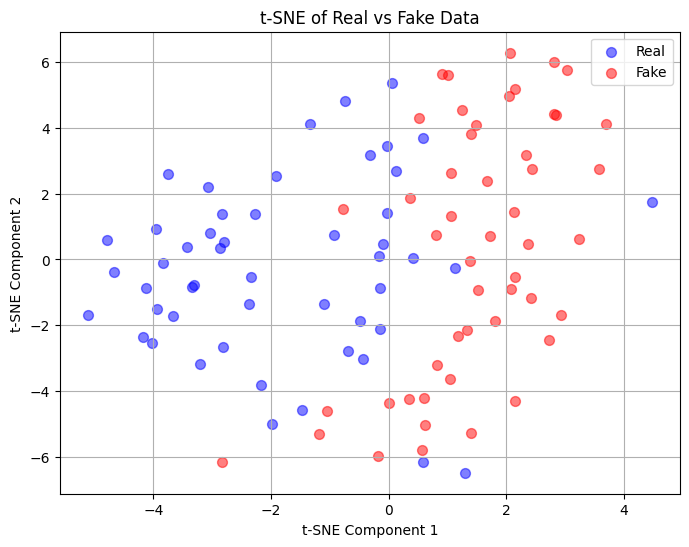

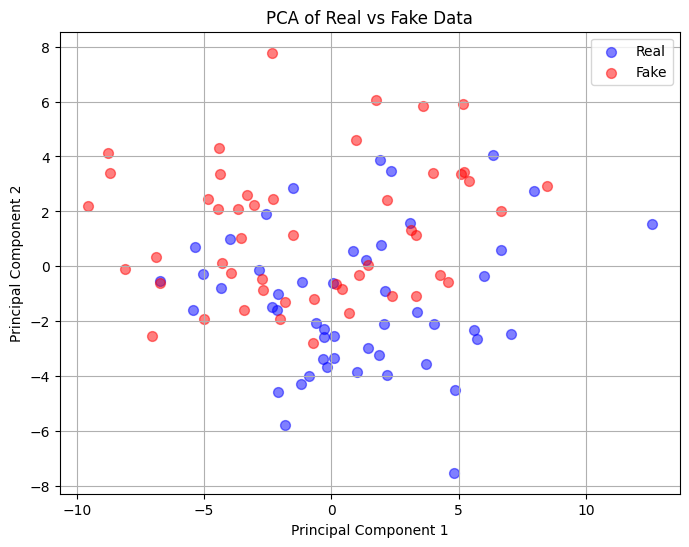

In [ ]:
all_real_combined = pd.concat([pd.DataFrame(pca_data_all_basic_features(50,paths_real,'2', 0)),
                               pd.DataFrame(pca_data_all_basic_features(50,paths_real,'3', 1)),
                               pd.DataFrame(pca_data_all_basic_features(50,paths_real,'4', 2))], axis = 1)
all_fake_combined = pd.concat([pd.DataFrame(pca_data_all_basic_features(50,paths_fake,'2', 0)),
                               pd.DataFrame(pca_data_all_basic_features(50,paths_fake,'3', 1)),
                               pd.DataFrame(pca_data_all_basic_features(50,paths_fake,'4', 2))], axis = 1)
draw_tsne(all_real_combined, all_fake_combined)
draw_pca(all_real_combined, all_fake_combined)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


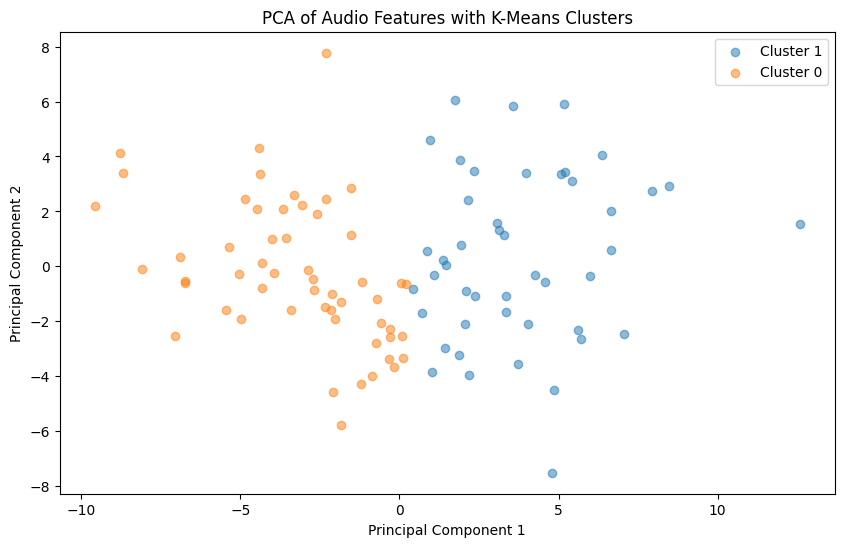

Confusion Matrix:
 [[25 25]
 [29 21]]

Classification Report:
               precision    recall  f1-score   support

        Real       0.46      0.50      0.48        50
        Fake       0.46      0.42      0.44        50

    accuracy                           0.46       100
   macro avg       0.46      0.46      0.46       100
weighted avg       0.46      0.46      0.46       100



In [ ]:
cluster_and_draw_pca(all_real_combined, all_fake_combined)

## Band Energy Ratio PCA

In [ ]:
all_real = pd.DataFrame(pca_data(50,paths_real))
all_fake = pd.DataFrame(pca_data(50,paths_fake))
draw_tsne(all_real, all_fake)
draw_pca(all_real, all_fake)
cluster_and_draw_pca(all_real, all_fake)

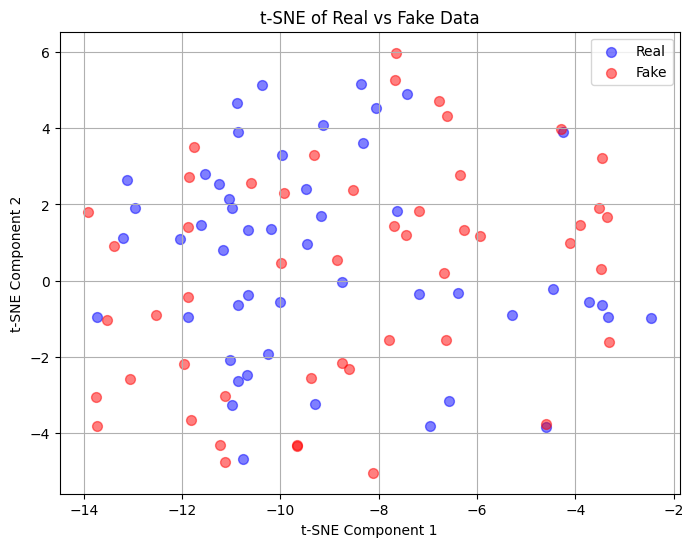

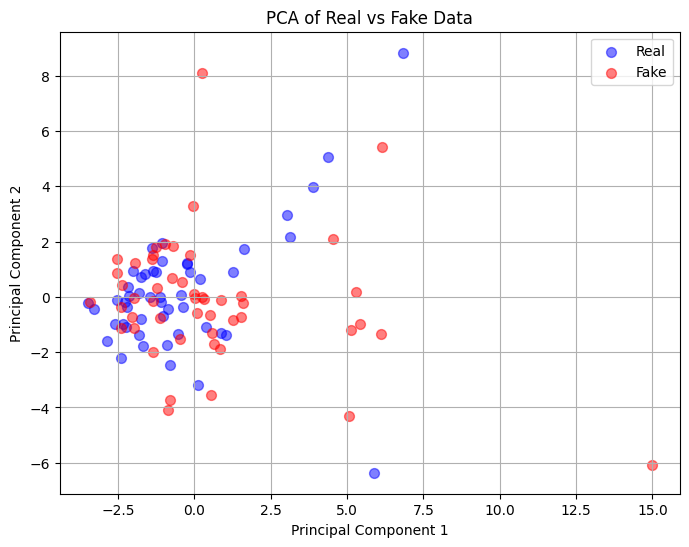

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


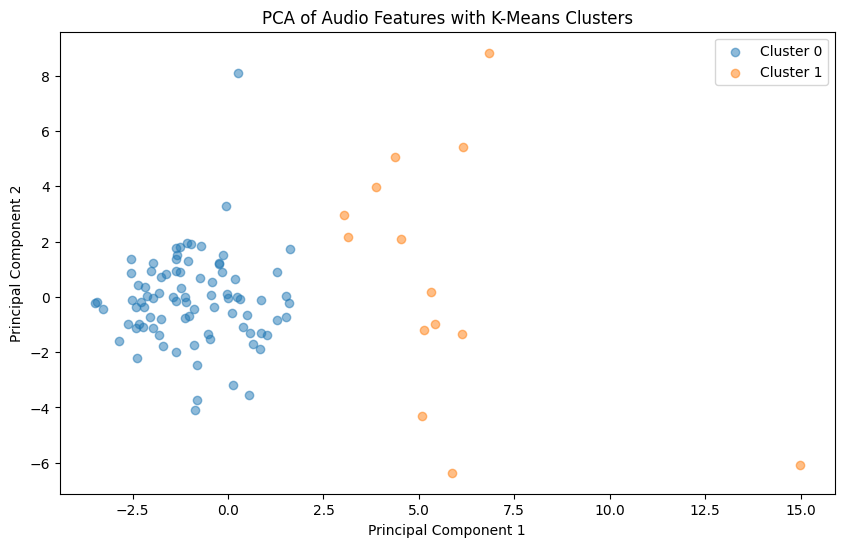

Confusion Matrix:
 [[44  6]
 [42  8]]

Classification Report:
               precision    recall  f1-score   support

        Real       0.51      0.88      0.65        50
        Fake       0.57      0.16      0.25        50

    accuracy                           0.52       100
   macro avg       0.54      0.52      0.45       100
weighted avg       0.54      0.52      0.45       100



In [ ]:
all_real = pd.DataFrame(pca_data(50,paths_real))
all_fake = pd.DataFrame(pca_data(50,paths_fake))
draw_tsne(all_real, all_fake)
draw_pca(all_real, all_fake)
cluster_and_draw_pca(all_real, all_fake)

# PCA Crest Factor

In [ ]:
def crest_factor(signal, frame_size=1024, hop_length=512):
    """
    Computes the crest factor of a signal using a sliding window.

    Args:
        signal (array): The input signal.
        frame_size (int): The size of each frame in samples.
        hop_length (int): The number of samples between consecutive frames.

    Returns:
        np.array: An array of crest factor values.
    """
    res = []
    for i in range(0, len(signal), hop_length):
        # Get a portion of the signal
        cur_portion = signal[i:i + frame_size]
        # Compute the RMS energy for the portion
        rmse_val = np.sqrt(1 / len(cur_portion) * sum(i ** 2 for i in cur_portion))
        # Compute the crest factor
        crest_val = max(np.abs(cur_portion)) / rmse_val
        # Store the crest factor value
        res.append(crest_val)
    # Convert the result to a NumPy array
    return np.array(res)

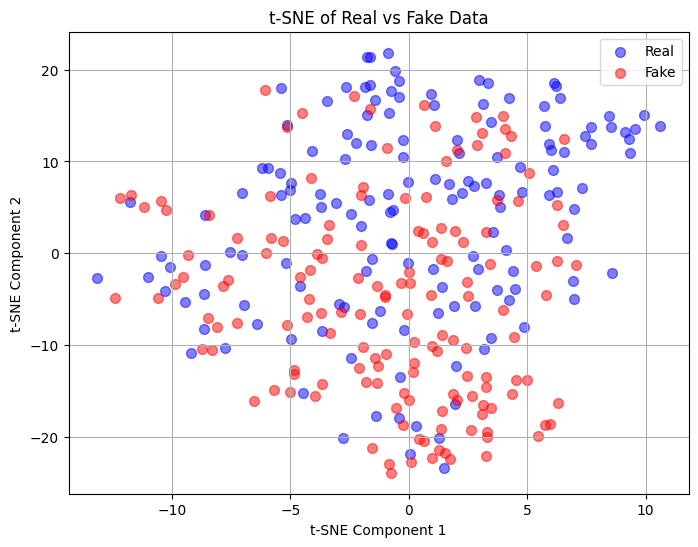

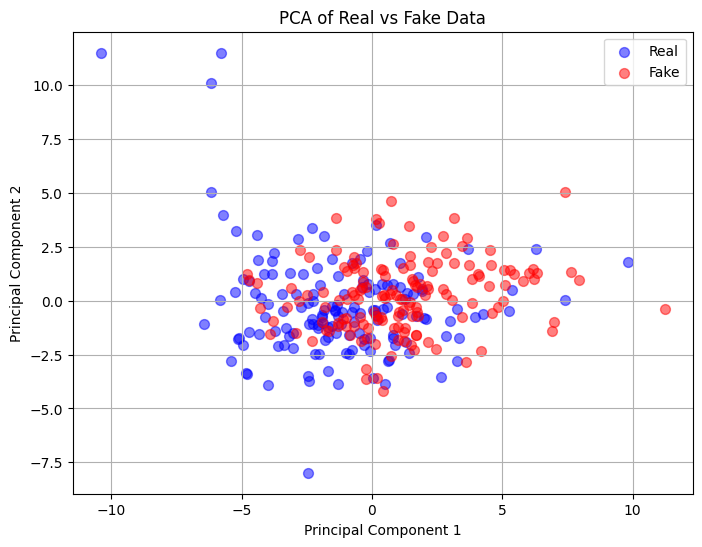

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


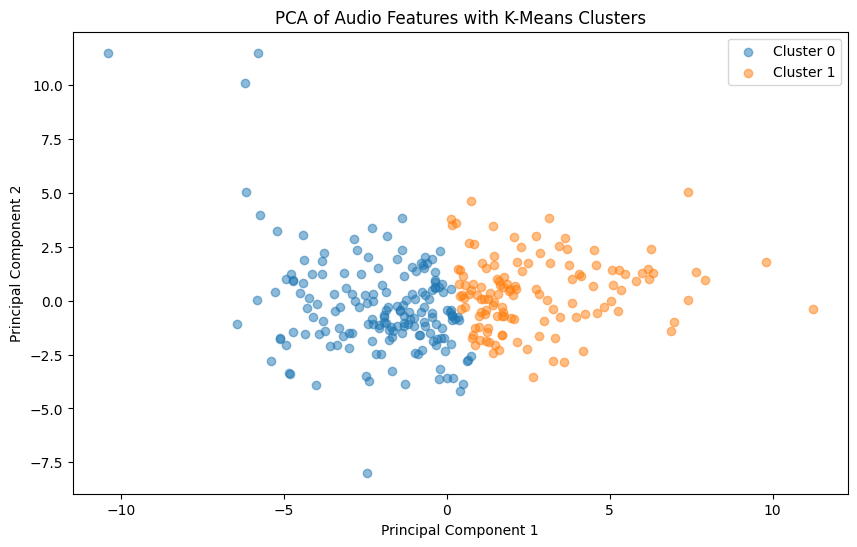

Confusion Matrix:
 [[111  39]
 [ 60  90]]

Classification Report:
               precision    recall  f1-score   support

        Real       0.65      0.74      0.69       150
        Fake       0.70      0.60      0.65       150

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.67      0.67      0.67       300



In [ ]:
def pca_data_crest_factor(k, path_real_or_fake):
  feature_dict = {
      'mean': [],
      'std_dev': [],
      'variance': [],
      'min': [],
      'max': [],
      'median': [],
      'range': [],
      'skewness': [],
      'kurtosis': [],
      'quantile_10': [],
      'quantile_25': [],
      'quantile_50': [],
      'quantile_75': [],
      'quantile_90': [],
      'rolling_mean_3': [],
      'rolling_std_3': [],
      'num_peaks': [],
      'peak_heights': [],
      'entropy': [],
      'autocorrelation_lag1': [],
      'fft_real_mean': [],
      'fft_imag_mean': []
  }
  for i in range(k):
    x, sr = librosa.load(path_real_or_fake[i])
    df = crest_factor(x, 1024, 512)

    feature_dict['mean'].append(df.mean())
    feature_dict['std_dev'].append(df.std())
    feature_dict['variance'].append(df.var())
    feature_dict['min'].append(df.min())
    feature_dict['max'].append(df.max())
    feature_dict['median'].append(np.median(df))
    feature_dict['range'].append(df.max() - df.min())
    feature_dict['skewness'].append(skew(df))
    feature_dict['kurtosis'].append(kurtosis(df))
    feature_dict['quantile_10'].append(np.quantile(df, 0.1))
    feature_dict['quantile_25'].append(np.quantile(df, 0.25))
    feature_dict['quantile_50'].append(np.quantile(df, 0.5))
    feature_dict['quantile_75'].append(np.quantile(df, 0.75))
    feature_dict['quantile_90'].append(np.quantile(df, 0.9))

    rolling_mean_3 = pd.Series(df).rolling(window=3).mean()
    rolling_std_3 = pd.Series(df).rolling(window=3).std()
    feature_dict['rolling_mean_3'].append(rolling_mean_3.mean())
    feature_dict['rolling_std_3'].append(rolling_std_3.mean())

    peaks, _ = find_peaks(df)
    feature_dict['num_peaks'].append(len(peaks))
    feature_dict['peak_heights'].append(df[peaks].mean() if len(peaks) > 0 else 0)

    feature_dict['entropy'].append(entropy(pd.Series(df).value_counts()))

    feature_dict['autocorrelation_lag1'].append(pd.Series(df).autocorr(lag=1))

    fft_values = np.fft.fft(df)
    feature_dict['fft_real_mean'].append(np.mean(np.real(fft_values)))
    feature_dict['fft_imag_mean'].append(np.mean(np.imag(fft_values)))
  return feature_dict

all_real = pd.DataFrame(pca_data_crest_factor(150,paths_real))
all_fake = pd.DataFrame(pca_data_crest_factor(150,paths_fake))
draw_tsne(all_real, all_fake)
draw_pca(all_real, all_fake)
cluster_and_draw_pca(all_real, all_fake)

## PCA Pause Rate

In [ ]:
import librosa
import numpy as np

def detect_pauses_and_silences(signals, top_db=30):
    """
    Detect pauses and silences in an audio file using librosa.

    Parameters:
    - audio_file (str): Path to the audio file.
    - top_db (int): The threshold (in decibels) below reference to consider as silence. Default is 30 dB.

    Returns:
    - start_times (list of floats): List of start times of pauses in seconds.
    - end_times (list of floats): List of end times of pauses in seconds.
    - durations (list of floats): List of durations of pauses in seconds.
    """

    # Detect non-silent intervals
    non_silent_intervals = librosa.effects.split(signals, top_db=top_db)

    # Calculate silent intervals from non-silent intervals
    start_times = []
    end_times = []
    durations = []
    previous_end = 0.0

    for start, end in non_silent_intervals:
        if start > previous_end:
            start_time = previous_end / sr
            end_time = start / sr
            duration = end_time - start_time

            start_times.append(start_time)
            end_times.append(end_time)
            durations.append(duration)

        previous_end = end

    # Add final pause if there is a silence at the end
    if previous_end < len(x):
        start_time = previous_end / sr
        end_time = len(x) / sr
        duration = end_time - start_time

        start_times.append(start_time)
        end_times.append(end_time)
        durations.append(duration)

    return start_times, end_times, durations


In [ ]:
def pca_data_pause(k, path_real_or_fake, diff_k, start_end_duration_k):
  feature_dict = {
      'mean'+ diff_k: [],
      'std_dev'+ diff_k: [],
      'variance'+ diff_k: [],
      'min'+ diff_k: [],
      'max'+ diff_k: [],
      'median'+ diff_k: [],
      'range'+ diff_k: [],
      'skewness'+ diff_k: [],
      'kurtosis'+ diff_k: [],
      'quantile_10'+ diff_k: [],
      'quantile_25'+ diff_k: [],
      'quantile_50'+ diff_k: [],
      'quantile_75'+ diff_k: [],
      'quantile_90'+ diff_k: [],
      'rolling_mean_3'+ diff_k: [],
      'rolling_std_3'+ diff_k: [],
      'num_peaks'+ diff_k: [],
      'peak_heights'+ diff_k: [],
      'entropy'+ diff_k: [],
      'autocorrelation_lag1'+ diff_k: [],
      'fft_real_mean'+ diff_k: [],
      'fft_imag_mean'+ diff_k: []
  }
  for i in range(k):
    x, sr = librosa.load(path_real_or_fake[i])
    df = np.array(detect_pauses_and_silences(x)[start_end_duration_k])

    feature_dict['mean'+ diff_k].append(df.mean())
    feature_dict['std_dev'+ diff_k].append(df.std())
    feature_dict['variance'+ diff_k].append(df.var())
    feature_dict['min'+ diff_k].append(df.min())
    feature_dict['max'+ diff_k].append(df.max())
    feature_dict['median'+ diff_k].append(np.median(df))
    feature_dict['range'+ diff_k].append(df.max() - df.min())
    feature_dict['skewness'+ diff_k].append(skew(df))
    feature_dict['kurtosis'+ diff_k].append(kurtosis(df))
    feature_dict['quantile_10'+ diff_k].append(np.quantile(df, 0.1))
    feature_dict['quantile_25'+ diff_k].append(np.quantile(df, 0.25))
    feature_dict['quantile_50'+ diff_k].append(np.quantile(df, 0.5))
    feature_dict['quantile_75'+ diff_k].append(np.quantile(df, 0.75))
    feature_dict['quantile_90'+ diff_k].append(np.quantile(df, 0.9))

    rolling_mean_3 = pd.Series(df).rolling(window=3).mean()
    rolling_std_3 = pd.Series(df).rolling(window=3).std()
    feature_dict['rolling_mean_3'+ diff_k].append(rolling_mean_3.mean())
    feature_dict['rolling_std_3'+ diff_k].append(rolling_std_3.mean())

    peaks, _ = find_peaks(df)
    feature_dict['num_peaks'+ diff_k].append(len(peaks))
    feature_dict['peak_heights'+ diff_k].append(df[peaks].mean() if len(peaks) > 0 else 0)

    feature_dict['entropy'+ diff_k].append(entropy(pd.Series(df).value_counts()))

    feature_dict['autocorrelation_lag1'+ diff_k].append(pd.Series(df).autocorr(lag=1))

    fft_values = np.fft.fft(df)
    feature_dict['fft_real_mean'+ diff_k].append(np.mean(np.real(fft_values)))
    feature_dict['fft_imag_mean'+ diff_k].append(np.mean(np.imag(fft_values)))
  return feature_dict

# all_real = pd.DataFrame(pca_data_pause(50,paths_real,'2'))
# all_fake = pd.DataFrame(pca_data_pause(50,paths_fake,'2'))
# draw_tsne(all_real, all_fake)
# draw_pca(all_real, all_fake)

## Combined Features for PCA

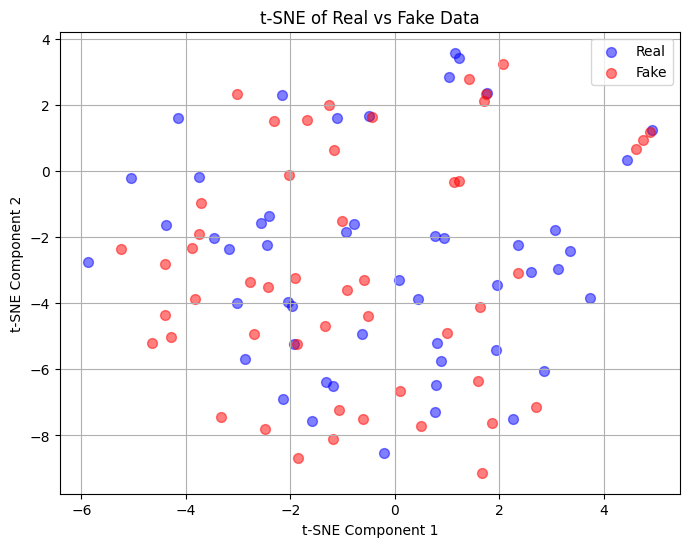

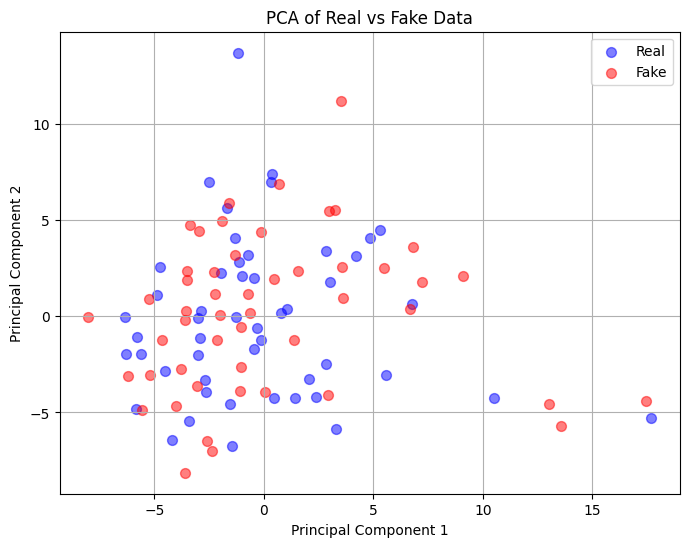

In [ ]:
all_real_combined = pd.concat([pd.DataFrame(pca_data_crest_factor(50,paths_real)), pd.DataFrame(pca_data_pause(50,paths_real,'2', 0)),
                               pd.DataFrame(pca_data_pause(50,paths_real,'3', 1)),
                               pd.DataFrame(pca_data_pause(50,paths_real,'4', 2))], axis = 1)
all_fake_combined = pd.concat([pd.DataFrame(pca_data_crest_factor(50,paths_fake)), pd.DataFrame(pca_data_pause(50,paths_fake,'2', 0)),
                               pd.DataFrame(pca_data_pause(50,paths_fake,'3', 1)),
                               pd.DataFrame(pca_data_pause(50,paths_fake,'4', 2))], axis = 1)
draw_tsne(all_real_combined, all_fake_combined)
draw_pca(all_real_combined, all_fake_combined)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


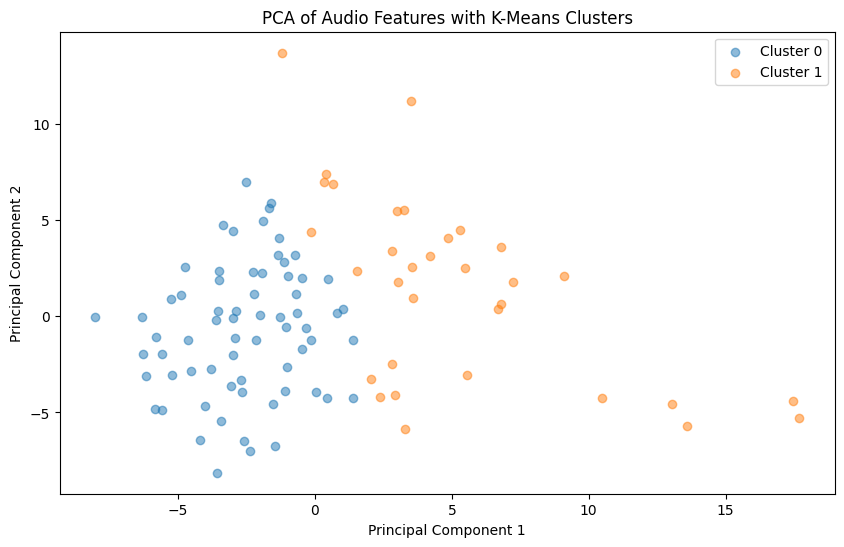

Confusion Matrix:
 [[34 16]
 [33 17]]

Classification Report:
               precision    recall  f1-score   support

        Real       0.51      0.68      0.58        50
        Fake       0.52      0.34      0.41        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.51      0.51      0.50       100



In [ ]:
cluster_and_draw_pca(all_real_combined, all_fake_combined)